In [12]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import numpy as np
import sklearn, sklearn.model_selection
import matplotlib
matplotlib.use('Agg');
import matplotlib.pyplot as plt
#plt.set_cmap('jet');
import random
import os, sys
import pickle
%matplotlib inline

In [2]:
import sys
import argparse

if len(sys.argv) == 3 and sys.argv[1] == "-f": #on jupyter
    sys.argv = ['a','-thing']
    
parser = argparse.ArgumentParser()

parser.add_argument('-seed', type=int, nargs='?',default=0, help='random seed for split and init')
parser.add_argument('-nsamples', type=int, nargs='?',default=50, help='Number of samples for train')
parser.add_argument('-thing', default=False, action='store_true', help='Do the thing')


args = parser.parse_args()

In [3]:
print(args)

Namespace(nsamples=50, seed=0, thing=True)


In [4]:
exp_id = str(args).replace(" ","").replace("Namespace(","").replace(")","").replace(",","-").replace("=","")
print(exp_id)

nsamples50-seed0-thingTrue


In [5]:
torch.manual_seed(args.seed);
random.seed(args.seed)

In [6]:
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
cuda = torch.cuda.is_available()

In [8]:
BATCH_SIZE = 128

In [9]:
from torch.utils import data
import os
import skimage, skimage.transform
from skimage.io import imread, imsave

In [10]:
from PIL import Image
import skimage.filters

In [11]:
class TNTDataset(data.Dataset):
    'Tumor-NoTumor Dataset loader for PyTorch'
    def __init__(self, tntpath, subset="train", transform=None, blur=0):
        self.tntpath = tntpath
        self.subset = subset
        self.datapath = self.tntpath + "/" + self.subset + "/"
        self.imgs = sorted(os.listdir(self.datapath + "/flair"))
        self.transform = transform
        self.blur = blur

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        # Select sample
        filename = self.imgs[index]
        
        flair = imread(self.datapath + "/flair/" + filename)
        flair = Image.fromarray(flair)
        if self.transform != None:
            flair = self.transform(flair)
            
#         t1 = imread(self.datapath + "/t1/" + filename)
#         t1 = Image.fromarray(t1)
#         if self.transform != None:
#             t1 = self.transform(t1)
            
        seg = imread(self.datapath + "/segmentation/" + filename)
        seg = ((seg >= 30))*256.
        
        if self.blur > 0:
            seg = skimage.filters.gaussian(seg, self.blur)
            seg = seg/seg.max()
            
        seg = (seg > 0)*1.
        
        seg = Image.fromarray(seg)
        if self.transform != None:
            seg = self.transform(seg)
        
        
        has_tumor = ("True" in filename)

        return (flair, flair, seg), has_tumor 

In [12]:
mytransform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(100),
    torchvision.transforms.ToTensor()])

In [13]:
train = TNTDataset("/data/lisa/data/brats2013_tumor-notumor/", 
                   transform=mytransform,
                   blur=3)

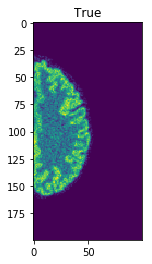

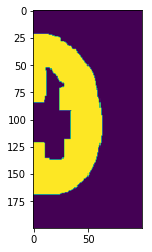

In [14]:
plt.imshow(train[5][0][0][0]);
plt.title(train[5][1]);
plt.show()
plt.imshow(train[5][0][2][0]);

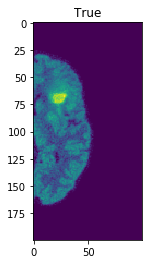

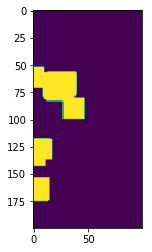

In [15]:
plt.imshow(train[250][0][0][0]);
plt.title(train[250][1]);
plt.show()
plt.imshow(train[250][0][2][0]);

In [16]:
# def f(x):
#     plt.imshow(train[x][0][1][0]);
#     plt.title(train[x][1]);
#     plt.show()
#     plt.imshow(train[x][0][2][0]);

# interact(f, x=(0,len(train),1));

In [17]:
tosplit = np.asarray([("True" in name) for name in train.imgs])
idx = range(tosplit.shape[0])
train_idx, valid_idx = sklearn.model_selection.train_test_split(idx, stratify=tosplit, train_size=0.75, random_state=args.seed)


/u/cohenjos/.local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [18]:
import collections
collections.Counter(tosplit)

Counter({False: 704, True: 1421})

In [19]:
print ("train_idx", len(train_idx))
print ("valid_idx", len(valid_idx))

train_idx 1593
valid_idx 532


In [20]:
#reduce samples
train_idx = train_idx[:args.nsamples]

In [21]:
print ("train_idx", len(train_idx))
print ("valid_idx", len(valid_idx))

train_idx 50
valid_idx 532


In [22]:
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=BATCH_SIZE, 
                                          sampler=torch.utils.data.sampler.SubsetRandomSampler(train_idx),
                                          num_workers=8)
valid_loader = torch.utils.data.DataLoader(dataset=train, batch_size=len(valid_idx), 
                                          sampler=torch.utils.data.sampler.SubsetRandomSampler(valid_idx),
                                          num_workers=8)

In [23]:
valid_data = list(valid_loader)
valid_x = Variable(valid_data[0][0][0]).cuda()
valid_y = valid_data[0][1].cuda()

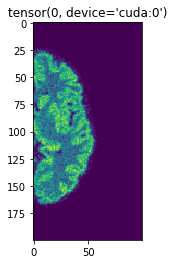

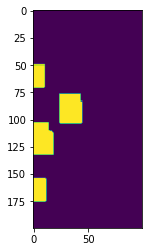

In [24]:
plt.imshow(valid_data[0][0][0][60][0]);
plt.title(valid_y[60]);
plt.show()
plt.imshow(valid_data[0][0][2][60][0]);


In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=64,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),     
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64,
                out_channels=32,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=32,
                out_channels=16,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=8,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),
            nn.ReLU(),
        )
        self.out = nn.Linear(440, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x

In [92]:
cnn = CNN()
if cuda:
    cnn = cnn.cuda()

print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU()
  )
  (out): Linear(in_features=440, out_features=2, bias=True)
)


In [93]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [94]:
use_gradmask = args.thing
stats = []

for epoch in range(500):
    batch_loss = []
    for step, (x, y) in enumerate(train_loader):
        
        b_x = Variable(x[0], requires_grad=True)
        b_y = Variable(y)
        seg_x = x[2]
        
        if cuda:
            b_x = b_x.cuda()
            b_y = b_y.cuda()
            seg_x = seg_x.cuda()

        cnn.train()
        output = cnn(b_x)[0]
        loss = loss_func(output, b_y)
        
        if use_gradmask:
            input_grads = torch.autograd.grad(outputs=torch.abs(output[:,1]).sum(), #loss,#torch.abs(output).sum(), 
                                       inputs=b_x, 
                                       #retain_graph=True, 
                                       create_graph=True)[0]
            
            #only apply to positive examples
            input_grads = b_y.float().reshape(-1,1,1,1)*input_grads
            
            res = input_grads * (1-seg_x.float())
            #res = torch.abs(res)
            gradmask_loss = epoch*(res**2).sum()
            loss = loss + gradmask_loss
            
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        batch_loss.append(loss.data[0])
        #print (loss)
    
    cnn.eval()
    test_output, last_layer = cnn(valid_x)
    pred_y = torch.max(test_output, 1)[1].data.squeeze()
    #accuracy = float(sum(pred_y == valid_y.cuda())) / float(valid_y.size(0))
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_y.cpu())
    stat = {"epoch":epoch,
            "trainloss":np.asarray(batch_loss).mean(),
            "validauc": auc}
    stat.update(vars(args))
    stats.append(stat)
    print('Epoch: ', epoch, '| train loss: %.4f' % np.asarray(batch_loss).mean(), '| valid auc: %.2f' % auc)
    #os.mkdir("stats")
    pickle.dump(stats, open("stats/" + exp_id + ".pkl","wb"))     


Epoch:  0 | train loss: 0.7003 | valid auc: 0.50


a:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch:  1 | train loss: 0.7011 | valid auc: 0.50
Epoch:  2 | train loss: 0.6971 | valid auc: 0.50
Epoch:  3 | train loss: 0.6964 | valid auc: 0.50
Epoch:  4 | train loss: 0.6928 | valid auc: 0.50
Epoch:  5 | train loss: 0.6889 | valid auc: 0.50
Epoch:  6 | train loss: 0.6865 | valid auc: 0.50


KeyboardInterrupt: 

In [ ]:
#loss*10000*(res**2).sum()

In [1]:
import pickle
#os.mkdir("stats")
pickle.dump(stats, open("stats/" + exp_id + ".pkl","w"))   

NameError: name 'stats' is not defined

In [46]:
sys.exit()

SystemExit: 

To exit: use 'exit', 'quit', or Ctrl-D.


In [ ]:
##############################################
##############################################
##############################################
##############################################
## below is code to debug the model

In [35]:
x, y = train[250]

In [36]:
x[0].shape

torch.Size([1, 200, 100])

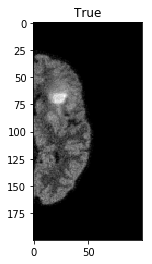

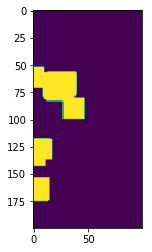

In [37]:
plt.imshow(x[0][0], cmap="gray");
plt.title(y);
plt.show()
plt.imshow(x[2][0]);

In [38]:
x_var = Variable(x[0].unsqueeze(0).cuda(), requires_grad=True)
pred = cnn(x_var)[0]

In [39]:
pred

tensor([[ 4.6118,  0.0441]], device='cuda:0')

In [40]:
input_grads = torch.autograd.grad(outputs=torch.abs(pred[:,1]).sum(), 
                                       inputs=x_var,
                                       create_graph=True)[0]

In [41]:
input_grads = input_grads[0][0].cpu().detach().numpy()

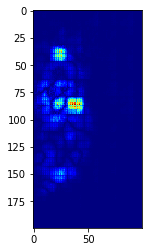

In [42]:
plt.imshow(np.abs(input_grads), cmap="jet");

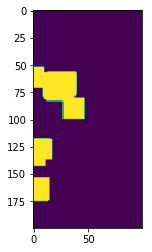

In [43]:
plt.imshow(x[2][0])

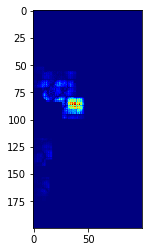

In [44]:
#these are the only allowed grads
masked_grads = np.abs(input_grads)*(x[2][0])
masked_grads[0][0] = torch.FloatTensor(np.abs(input_grads)).max()
plt.imshow(masked_grads, cmap="jet")

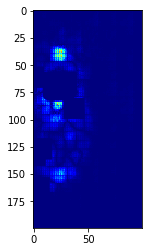

In [45]:
#We can regularize to reduce this
masked_grads = np.abs(input_grads)*(1-x[2][0])
masked_grads[0][0] = torch.FloatTensor(np.abs(input_grads)).max()
plt.imshow(masked_grads, cmap="jet")

In [ ]:
import skimage.filters
enlarged_mask = skimage.filters.gaussian(x[2][0].numpy(),15)
enlarged_mask = enlarged_mask/enlarged_mask.max()
enlarged_mask.max()

In [ ]:
plt.imshow(enlarged_mask)

In [59]:
#assuming the segmentations are sloppy we can enlarge the segmentations
masked_grads = input_grads*(1-enlarged_mask)
plt.imshow(masked_grads)

NameError: name 'enlarged_mask' is not defined

In [ ]:
#torch.save(cnn.state_dict(), "./classifier_model.pth")

In [18]:
# checkpoint = torch.load("./classifier_model.pth")
# cnn.load_state_dict(checkpoint)

In [ ]:
# cnn.eval()
# test_output, last_layer = cnn(valid_x)
# pred_y = torch.max(test_output, 1)[1].data.squeeze()
# accuracy = float((pred_y == valid_y).sum()) / float(valid_y.size(0))
# print 'valid accuracy: %.2f' % accuracy

In [ ]:
##############################################
##############################################
##############################################
##############################################
## below is code to plot the results of running this with "run.sh classify.ipynb"
## e.g "run.sh classify.ipynb -thing -nsamples 32 -seed 4"
## it writes a pickle file with the results for each run.


In [2]:
import pandas, os, pickle

In [3]:
df = pandas.DataFrame()
for f in os.listdir("stats"):
    d = (pickle.load(open("stats/" + f,"rb")))
    df = df.append(pandas.DataFrame(d))

In [4]:
df.nsamples.unique()

array([ 32, 128,  16,  64,   8,  10])

In [10]:
df[(df.nsamples == 8)].groupby(["epoch","thing"]).count()

nsamples  seed  trainloss  validauc
epoch thing                                     
0     False        21    21         21        21
      True         21    21         21        21
1     False        21    21         21        21
      True         21    21         21        21
2     False        21    21         21        21
      True         21    21         21        21
3     False        21    21         21        21
      True         21    21         21        21
4     False        21    21         21        21
      True         21    21         21        21
5     False        21    21         21        21
      True         21    21         21        21
6     False        21    21         21        21
      True         21    21         21        21
7     False        21    21         21        21
      True         21    21         21        21
8     False        21    21         21        21
      True         21    21         21        21
9     False        21    21         21        21
      True         21    21         21        21
10    False        21    21         21        21
      True         21    21         21        21
11    False        21    21         21        21
      True         21    21         21        21
12    False        21    21         21        21
      True         21    21         21        21
13    False        21    21         21        21
      True         21    21         21        21
14    False        21    21         21        21
      True         21    21         21        21
...               ...   ...        ...       ...
485   False        21    21         21        21
      True         21    21         21        21
486   False        21    21         21        21
      True         21    21         21        21
487   False        21    21         21        21
      True         21    21         21        21
488   False        21    21         21        21
      True         21    21         21        21
489   False        21    21         21        21
      True         21    21         21        21
490   False        21    21         21        21
      True         21    21         21        21
491   False        21    21         21        21
      True         21    21         21        21
492   False        21    21         21        21
      True         21    21         21        21
493   False        21    21         21        21
      True         21    21         21        21
494   False        21    21         21        21
      True         21    21         21        21
495   False        21    21         21        21
      True         21    21         21        21
496   False        21    21         21        21
      True         21    21         21        21
497   False        21    21         21        21
      True         21    21         21        21
498   False        21    21         21        21
      True         21    21         21        21
499   False        21    21         21        21
      True         21    21         21        21

[1000 rows x 4 columns]

In [7]:
df[(df.nsamples == 32)].groupby(["epoch","thing", "seed"]).mean()

nsamples     trainloss  validauc
epoch thing seed                                  
0     False 0           32  6.906266e-01  0.500000
            1           32  6.980248e-01  0.500000
            2           32  6.842324e-01  0.500000
            3           32  6.939053e-01  0.500000
            4           32  6.902745e-01  0.500000
            5           32  6.895733e-01  0.500000
            6           32  6.941712e-01  0.601092
            7           32  7.278176e-01  0.500000
            8           32  7.051064e-01  0.500000
            9           32  6.846712e-01  0.500000
            10          32  6.853570e-01  0.500000
            11          32  6.831104e-01  0.500000
            12          32  6.847941e-01  0.500000
            13          32  6.953641e-01  0.500000
            14          32  6.962835e-01  0.500000
            15          32  6.853898e-01  0.500000
            16          32  6.906127e-01  0.500000
            17          32  6.895761e-01  0.500000
            18          32  6.866560e-01  0.500000
            19          32  6.959667e-01  0.500000
            20          32  6.927395e-01  0.500000
      True  0           32  6.906266e-01  0.500000
            1           32  6.980248e-01  0.500000
            2           32  6.842324e-01  0.500000
            3           32  6.939053e-01  0.500000
            4           32  6.902745e-01  0.500000
            5           32  6.895733e-01  0.500000
            6           32  6.941712e-01  0.601092
            7           32  7.278176e-01  0.500000
            8           32  7.051064e-01  0.500000
...                    ...           ...       ...
499   False 12          32  8.419156e-07  0.637513
            13          32  2.206862e-05  0.713196
            14          32  3.544241e-05  0.754086
            15          32  8.375719e-04  0.717058
            16          32  4.500523e-05  0.722293
            17          32  6.241724e-05  0.664102
            18          32  2.277270e-05  0.733976
            19          32  1.224130e-05  0.695640
            20          32  2.406538e-06  0.805222
      True  0           32  2.284463e-02  0.768641
            1           32  1.745132e-02  0.701800
            2           32  4.454623e-02  0.659825
            3           32  1.085333e-01  0.681563
            4           32  5.559905e-03  0.768003
            5           32  1.158627e-02  0.786964
            6           32  2.192694e-02  0.768641
            7           32  2.103415e-01  0.535687
            8           32  7.238280e-03  0.814862
            9           32  4.511716e-03  0.806499
            10          32  5.444866e-02  0.761396
            11          32  2.453819e-02  0.767971
            12          32  1.817582e-02  0.719356
            13          32  1.133217e-02  0.725804
            14          32  8.834856e-02  0.749617
            15          32  2.926656e-02  0.786325
            16          32  5.331929e-02  0.765992
            17          32  1.194501e-01  0.676232
            18          32  5.653359e-02  0.797625
            19          32  9.194641e-03  0.714122
            20          32  3.723453e-02  0.822204

[21000 rows x 3 columns]

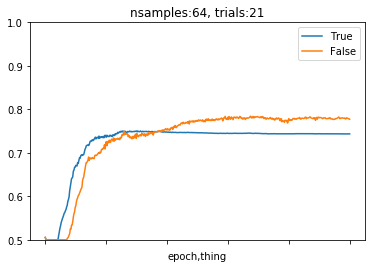

In [19]:
fig, ax = plt.subplots()
thisdata = df[(df.nsamples == 64)]
r = thisdata.groupby(["epoch","thing"]).mean().groupby("thing").plot(y="validauc", ax=ax)
plt.legend(df.thing.unique());
plt.title("nsamples:" + str(thisdata.nsamples.unique()[0]) + ", trials:" + str(thisdata.seed.unique().shape[0]));
plt.ylim(.5, 1.0);

In [189]:
r

thing
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

In [183]:
# fig, ax = plt.subplots()
# r = ss.mean().groupby("thing").plot(y="validauc", ax=ax, yerr=ss.std())
# #plt.legend(r)
